# Semantic Segmentation

Image semantic segmentation is more and more being of interest for computer vision and machine learning researchers. Many applications on the rise need accurate and efficient segmentation mechanisms: autonomous driving, indoor navigation, and even virtual or augmented reality systems to name a few. This work label the pixels of a road in images using a [Fully Convolutional Network (FCN)](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf).

I implementing the model using [Kitti Road dataset](http://www.cvlibs.net/datasets/kitti/eval_road.php). You can download the dataset from [here](http://www.cvlibs.net/download.php?file=data_road.zip). Extract the dataset in the `data` folder. This will create the folder data_road with all the training a test images. For the pre-processing process, I have build a `kitti.py` file to load data and build batch generator, using `kitti_source()` to run it.

## Check the KITTI dataset.

In [21]:
import math
import os
import numpy as np
import cv2
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kitti
%matplotlib inline

In [6]:
get_source=kitti.get_source()
get_source.load_data('data/data_road',0.1)

train_generator=get_source.train_generator
valid_generator = get_source.valid_generator
label_colors = get_source.label_colors

In [11]:
print('[i] # training samples:   ', get_source.num_training)
print('[i] # validation samples: ', get_source.num_validation)
print('[i] # classes:            ', get_source.num_classes)
print('[i] Image size:           ', get_source.image_size)

[i] # training samples:    261
[i] # validation samples:  28
[i] # classes:             2
[i] Image size:            (576, 160)


The function that we might need in the preprocessing.

In [14]:
def draw_labels(img, labels, label_colors, convert=True):
    """
    Draw the labels on top of the input image
    :param img:          the image being classified
    :param labels:       the output of the neural network
    :param label_colors: the label color map defined in the source
    :param convert:      should the output be converted to RGB
    """
    labels_colored = np.zeros_like(img)
    for label in label_colors:
        label_mask = labels == label
        labels_colored[label_mask] = label_colors[label]
    img = cv2.addWeighted(img, 1, labels_colored, 0.8, 0)
    if not convert:
        return img
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def draw_labels_batch(imgs, labels, label_colors, convert=True):
    """
    Perform `draw_labels` on all the images in the batch
    """
    imgs_labelled = np.zeros_like(imgs)
    for i in range(imgs.shape[0]):
        imgs_labelled[i, :, :, :] = draw_labels(imgs[i, :, :, :],
                                                labels[i, :, :],
                                                label_colors,
                                                convert)
    return imgs_labelled

Store 10 annotated training samples in the `output`.

Noted that although we see that the image is a little wierd, it seems quiet right in the output folder.

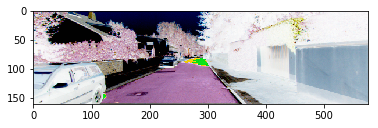

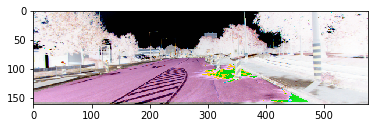

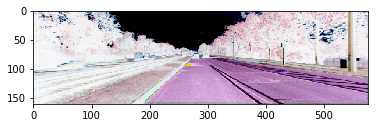

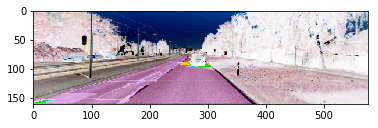

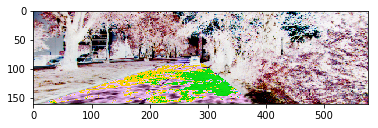

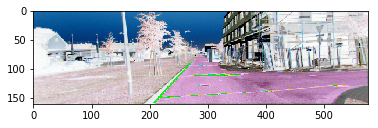

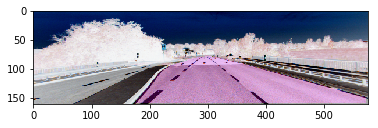

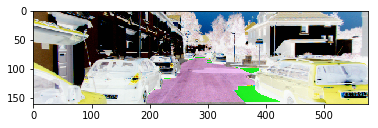

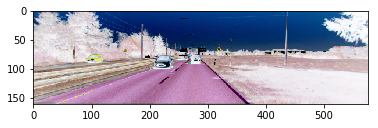

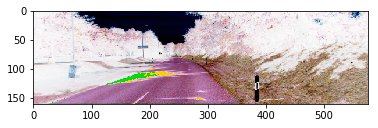

In [23]:
gen = get_source.train_generator(10)
x, y = next(gen)
output_dir='output'# Store output images

labels = tf.placeholder(tf.float32,shape=[None, None, None, get_source.num_classes])
label_mapper = tf.argmax(labels, axis=3)

with tf.Session() as sess:
    y_mapped = sess.run(label_mapper, feed_dict={labels: y})

imgs_labelled = draw_labels_batch(x, y_mapped, get_source.label_colors, False)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
for i in range(x.shape[0]):
    filename = 'outpout_{:04d}.png'.format(i)
    plt.figure()
    plt.imshow(imgs_labelled[i, :, :, :])
    cv2.imwrite(output_dir + '/' + filename, imgs_labelled[i, :, :, :])

In [27]:
# Check if all the labels are correct

def check_label_validity(y, ny):
    # Check validity of the lavel
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            for k in range(y.shape[2]):
                nnzeros = np.count_nonzero(y[i, j, k, :])
                has_one = 1 in y[i, j, k, :]
                if nnzeros != 1 or not has_one:
                    print('{} label for pixel ({}, {}) is invalid'.format(ny[i], j, k))
                    print(y[i, j, k, :])
                    
gen = get_source.train_generator(10, names=True)
n_batches = int(math.ceil(get_source.num_training / 10))

for x, y, nx, ny in tqdm(gen, total=n_batches,
                         desc='Checking training labels', unit='batches'):
    check_label_validity(y, ny)

[i] Checking training labels: 100%|████████████████████| 27/27 [03:15<00:00,  5.61s/batches]
